**IMPORTS**


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


**DATASET GENERATION**

In [30]:
duration_sec = 10
fs = 1000
N = duration_sec * fs

time_ms = np.arange(N)

# Baseline
voltage = 230 + np.random.normal(0, 0.5, N)
current = 10 + np.random.normal(0, 0.3, N)
temperature = 35 + np.random.normal(0, 0.1, N)

# DEADLY FAULT: 2s–9s
fault_idx = (time_ms > 2000) & (time_ms < 9000)

# Voltage instability
voltage[fault_idx] += 50 * np.sin(0.015 * time_ms[fault_idx])

# Current collapse + surge
current[fault_idx] *= np.where(
    np.sin(0.02 * time_ms[fault_idx]) > 0,
    3.0,
    0.05
)

# Temperature runaway
temperature[fault_idx] += np.linspace(0, 30, fault_idx.sum())

df = pd.DataFrame({
    "time_ms": time_ms,
    "voltage": voltage,
    "current": current,
    "temperature": temperature
})

df.head()


,time_ms,voltage,current,temperature
0,0,229.478400,10.164696,35.000892
1,1,229.745246,9.872528,34.944498
2,2,230.602307,9.882537,34.994743
3,3,229.846138,9.844707,34.986206
4,4,230.264516,9.996210,35.050176


**SLIDING WINDOW(rate of change)**



In [31]:
WINDOW = 100  # 100 ms

dV, dC, dT = [], [], []

for i in range(WINDOW, len(df)):
    dV.append((df.voltage[i] - df.voltage[i-WINDOW]) / WINDOW)
    dC.append((df.current[i] - df.current[i-WINDOW]) / WINDOW)
    dT.append((df.temperature[i] - df.temperature[i-WINDOW]) / WINDOW)

dV = np.array(dV)
dC = np.array(dC)
dT = np.array(dT)


**NORMALIZATION**

In [32]:
def normalize(x):
    x = np.abs(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

dVn = normalize(dV)
dCn = normalize(dC)
dTn = normalize(dT)


**INDEPENDENT THERMAL INESITIES(V,C,T)**

In [33]:
H_V = gaussian_filter1d(dVn, sigma=25)
H_C = gaussian_filter1d(dCn, sigma=25)
H_T = gaussian_filter1d(dTn, sigma=25)

def renorm(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

H_V = renorm(H_V)
H_C = renorm(H_C)
H_T = renorm(H_T)


**FUSING THERMAL INTENSITIES**

In [34]:
wV, wC, wT = 0.3, 0.4, 0.3
H_fused = wV*H_V + wC*H_C + wT*H_T
H_fused = np.clip(H_fused, 0, 1)


**TIME AXIS OF HEATMAPS**

In [35]:
time_axis_sec = time_ms[WINDOW:] / 1000.0
HEIGHT = 35


**VOLTAGE HEATMAP**


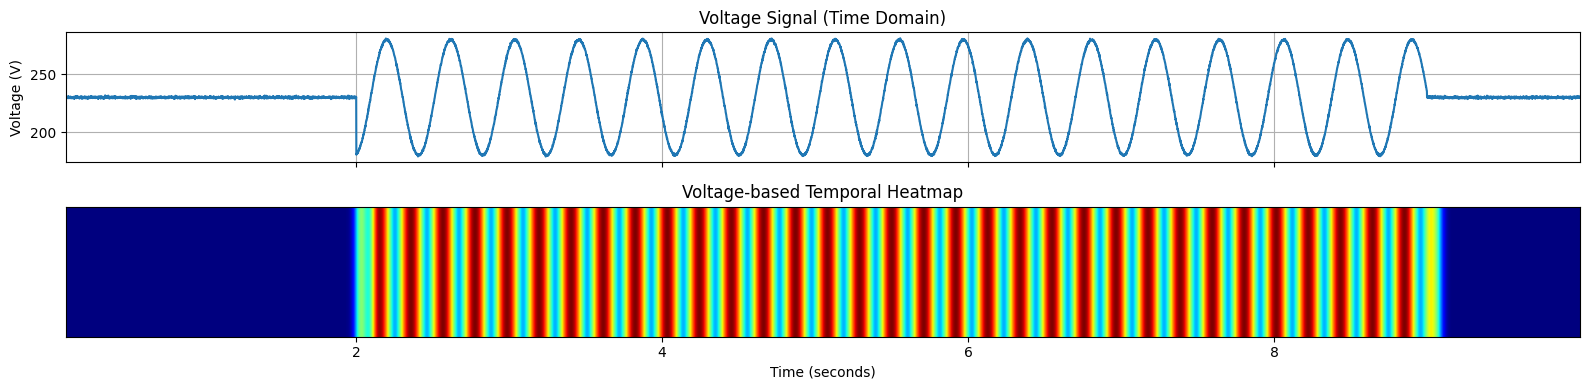

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(16,4), sharex=True)

# ---- Normal Voltage Graph ----
axes[0].plot(time_axis_sec, df.voltage[WINDOW:])
axes[0].set_title("Voltage Signal (Time Domain)")
axes[0].set_ylabel("Voltage (V)")
axes[0].grid(True)

# ---- Voltage Heatmap ----
axes[1].imshow(
    np.tile(H_V, (20,1)),
    cmap="jet",
    aspect="auto",
    extent=[time_axis_sec[0], time_axis_sec[-1], 0, 1]
)
axes[1].set_title("Voltage-based Temporal Heatmap")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


**CURRENT** **HEATMAP**

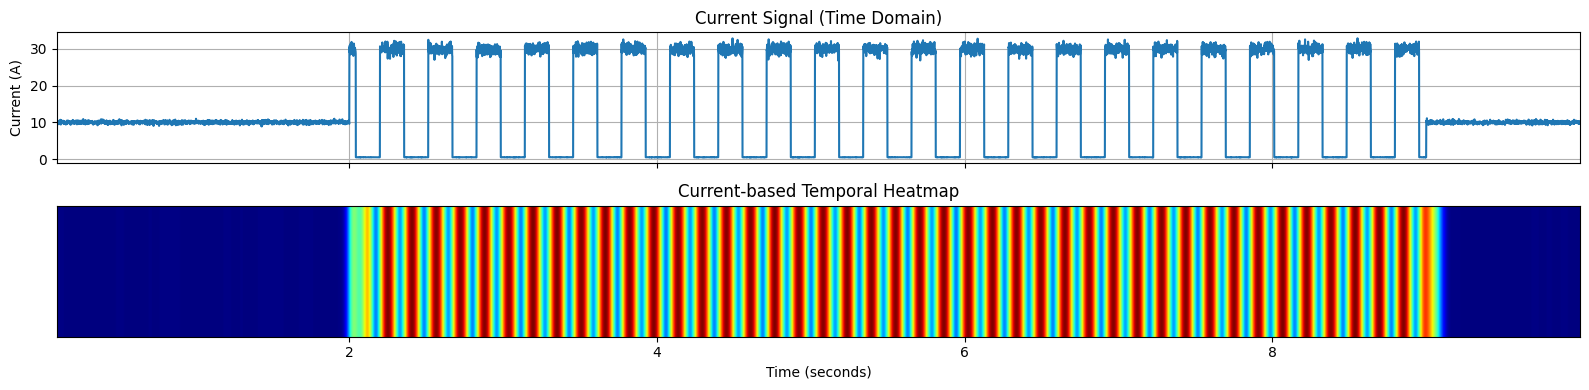

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(16,4), sharex=True)

# ---- Normal Current Graph ----
axes[0].plot(time_axis_sec, df.current[WINDOW:])
axes[0].set_title("Current Signal (Time Domain)")
axes[0].set_ylabel("Current (A)")
axes[0].grid(True)

# ---- Current Heatmap ----
axes[1].imshow(
    np.tile(H_C, (20,1)),
    cmap="jet",
    aspect="auto",
    extent=[time_axis_sec[0], time_axis_sec[-1], 0, 1]
)
axes[1].set_title("Current-based Temporal Heatmap")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


**TEMPERATURE HEATMAP**

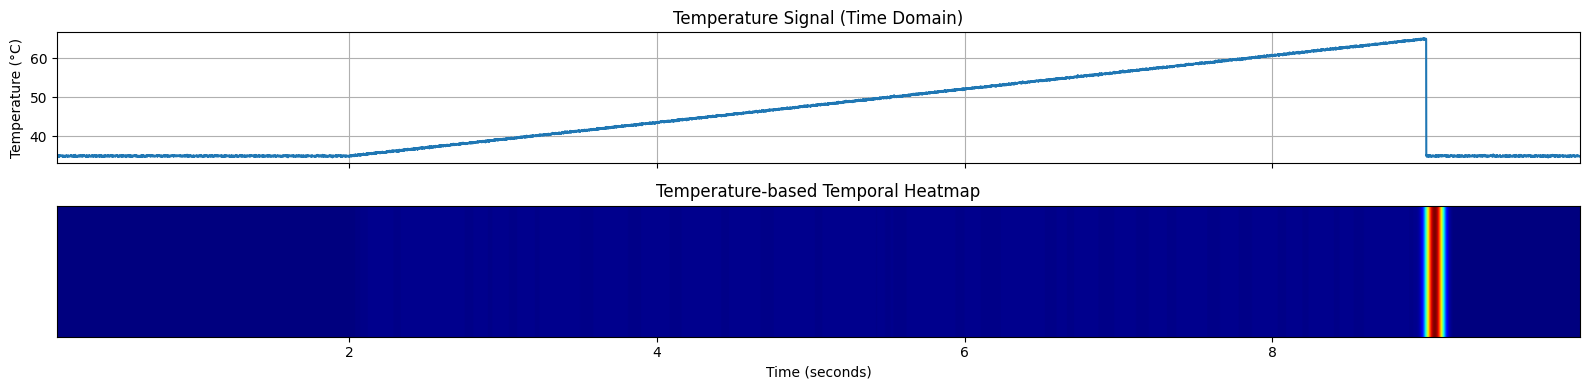

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(16,4), sharex=True)

# ---- Normal Temperature Graph ----
axes[0].plot(time_axis_sec, df.temperature[WINDOW:])
axes[0].set_title("Temperature Signal (Time Domain)")
axes[0].set_ylabel("Temperature (°C)")
axes[0].grid(True)

# ---- Temperature Heatmap ----
axes[1].imshow(
    np.tile(H_T, (20,1)),
    cmap="jet",
    aspect="auto",
    extent=[time_axis_sec[0], time_axis_sec[-1], 0, 1]
)
axes[1].set_title("Temperature-based Temporal Heatmap")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


**FUSED** **HEATMAP**

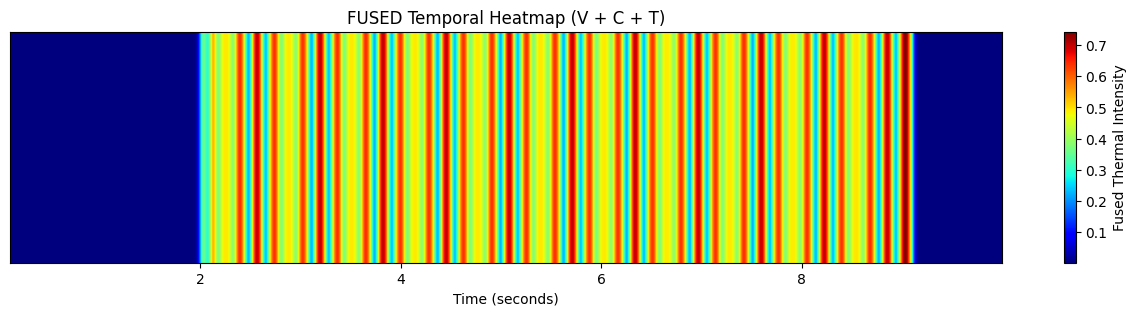

In [39]:
plt.figure(figsize=(16,3))
plt.imshow(
    np.tile(H_fused, (HEIGHT,1)),
    cmap="jet",
    aspect="auto",
    extent=[time_axis_sec[0], time_axis_sec[-1], 0, HEIGHT]
)
plt.colorbar(label="Fused Thermal Intensity")
plt.xlabel("Time (seconds)")
plt.title("FUSED Temporal Heatmap (V + C + T)")
plt.yticks([])
plt.show()


**THERMAL STRESS SIGNATURE**

In [40]:
flat_vals = thermal_field.flatten()

cold_ratio    = (flat_vals < 0.20).mean()
warning_ratio = ((flat_vals >= 0.60) & (flat_vals < 0.80)).mean()
hot_ratio     = (flat_vals >= 0.80).mean()

mean_intensity = flat_vals.mean()
variance_intensity = flat_vals.var()

numeric_vector = {
    "cold_ratio": cold_ratio,
    "warning_ratio": warning_ratio,
    "hot_ratio": hot_ratio,
    "mean_intensity": mean_intensity,
    "variance": variance_intensity
}

numeric_vector


{'cold_ratio': np.float64(0.8133333333333334),
 'warning_ratio': np.float64(0.00909090909090909),
 'hot_ratio': np.float64(0.0034343434343434343),
 'mean_intensity': np.float64(0.10903131877643227),
 'variance': np.float64(0.013109067009082858)}

**BINARY OUTPUT**

In [41]:
binary_vector = {
    "ColdFault": int(
        numeric_vector["cold_ratio"] > 0.30 and
        numeric_vector["mean_intensity"] > 0.20
    ),
    "WarningState": int(
        numeric_vector["warning_ratio"] > 0.40
    ),
    "HotFault": int(
        numeric_vector["hot_ratio"] > 0.15
    ),
    "UnstableBehavior": int(
        numeric_vector["variance"] > 0.02
    )
}

print("FINAL NUMERIC FEATURE VECTOR")
for k, v in numeric_vector.items():
    print(f"{k:20s}: {v:.4f}")

print("\nFINAL BINARY SIGNATURE")
for k, v in binary_vector.items():
    print(f"{k:20s}: {v}")


FINAL NUMERIC FEATURE VECTOR
cold_ratio          : 0.8133
warning_ratio       : 0.0091
hot_ratio           : 0.0034
mean_intensity      : 0.1090
variance            : 0.0131

FINAL BINARY SIGNATURE
ColdFault           : 0
WarningState        : 0
HotFault            : 0
UnstableBehavior    : 0
